In [1]:
pip install opencv-python numpy ultralytics keras-facenet scikit-learn joblib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
# CELL 1: Import Library & Konfigurasi Path
import os
import cv2
import numpy as np
from ultralytics import YOLO
from keras_facenet import FaceNet
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import joblib
import matplotlib.pyplot as plt

# Konfigurasi Path Dataset
# Sesuaikan string path ini agar tepat mengarah ke folder Anda
BASE_DIR = r"D:\Semester 5\Deep Learning\Dataset Sistem Presensi Wajah V2.0\Dataset Sistem Presensi Wajah V2.0"
TRAIN_DIR = os.path.join(BASE_DIR, "Data train")

# Inisialisasi Model
# Gunakan 'yolov8n.pt' (standar) atau 'yolov8n-face.pt' (jika Anda sudah download bobot khusus wajah)
yolo_model = YOLO('yolov8n.pt') 
embedder = FaceNet()

print(f"Path dataset diatur ke: {BASE_DIR}")
print("Library berhasil di-load. Model YOLO dan FaceNet siap.")

Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\Pongo\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

Path dataset diatur ke: D:\Semester 5\Deep Learning\Dataset Sistem Presensi Wajah V2.0\Dataset Sistem Presensi Wajah V2.0
Library berhasil di-load. Model YOLO dan FaceNet siap.


In [9]:
# CELL 2: Preprocessing dengan Fitur RESUME + BACKUP (YOLO + Haar Cascade)

import time

# --- SETUP BACKUP DETECTOR (Haar Cascade) ---
# Ini digunakan jika YOLO gagal mendeteksi wajah
haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Setup Cache Folder
CACHE_DIR = os.path.join(BASE_DIR, "processed_cache_train")
if not os.path.exists(CACHE_DIR):
    os.makedirs(CACHE_DIR)
    print(f"Folder cache dibuat di: {CACHE_DIR}")
else:
    print(f"Menggunakan folder cache yang ada: {CACHE_DIR}")

X_faces = []
y_labels = []
files_skipped = []

# List file
files = [f for f in os.listdir(TRAIN_DIR) if f.endswith(('.jpg', '.jpeg', '.png'))]
total_files = len(files)

print(f"Total file: {total_files}")
print("Memulai proses dengan strategi Hybrid (YOLO -> Fallback ke Haar Cascade)...")

start_time = time.time()

for i, filename in enumerate(files):
    
    # 1. Parsing Label
    parts = filename.split('_')
    if len(parts) >= 2:
        label = f"{parts[0]}_{parts[1]}"
    else:
        continue 

    # Path Cache
    cached_path = os.path.join(CACHE_DIR, filename)
    
    # --- LOGIKA 1: CEK CACHE ---
    if os.path.exists(cached_path):
        face_resized = cv2.imread(cached_path)
        face_resized = cv2.cvtColor(face_resized, cv2.COLOR_BGR2RGB)
        X_faces.append(face_resized)
        y_labels.append(label)
        
        if i % 50 == 0: print(f"[{i}/{total_files}] Cache: {filename}")
        continue # Lanjut ke file berikutnya

    # --- LOGIKA 2: JIKA TIDAK ADA DI CACHE, PROSES GAMBAR ---
    img_path = os.path.join(TRAIN_DIR, filename)
    image = cv2.imread(img_path)
    if image is None: continue
    
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    face_img_found = None # Variabel penampung hasil crop
    method_used = ""

    # === PLAN A: COBA PAKAI YOLO ===
    # Turunkan confidence ke 0.25 agar lebih sensitif
    results = yolo_model(rgb_image, verbose=False, conf=0.25)
    
    for result in results:
        boxes = result.boxes
        if len(boxes) > 0:
            # Ambil box dengan confidence tertinggi
            x1, y1, x2, y2 = map(int, boxes[0].xyxy[0])
            face_img_found = image[y1:y2, x1:x2] # Crop
            method_used = "YOLO"
            break # Sudah dapat, keluar loop boxes

    # === PLAN B: JIKA YOLO GAGAL, PAKAI HAAR CASCADE ===
    if face_img_found is None or face_img_found.size == 0:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Parameter: scaleFactor=1.1, minNeighbors=4
        faces_haar = haar_cascade.detectMultiScale(gray, 1.1, 4)
        
        if len(faces_haar) > 0:
            x, y, w, h = faces_haar[0] # Ambil wajah pertama
            face_img_found = image[y:y+h, x:x+w]
            method_used = "HAAR"

    # === SIMPAN HASILNYA ===
    if face_img_found is not None and face_img_found.size > 0:
        try:
            # Resize ke 160x160
            face_resized_bgr = cv2.resize(face_img_found, (160, 160))
            
            # Simpan ke Cache
            cv2.imwrite(cached_path, face_resized_bgr)
            
            # Simpan ke Memory (List)
            face_resized_rgb = cv2.cvtColor(face_resized_bgr, cv2.COLOR_BGR2RGB)
            X_faces.append(face_resized_rgb)
            y_labels.append(label)
            
            # Beri info jika pakai metode backup (Haar)
            if method_used == "HAAR":
                print(f"[{i}/{total_files}] Saved (via HAAR): {filename}")
                
        except Exception as e:
            print(f"Error resize/save pada {filename}: {e}")
            files_skipped.append(filename)
    else:
        # Jika Plan A dan Plan B gagal semua
        print(f"[{i}/{total_files}] GAGAL DETEKSI (Skip): {filename}")
        files_skipped.append(filename)

X_faces = np.array(X_faces)
y_labels = np.array(y_labels)

end_time = time.time()
print(f"\nSelesai! Durasi: {end_time - start_time:.2f} detik.")
print(f"Total Wajah: {len(X_faces)}")
if len(files_skipped) > 0:
    print(f"File gagal diproses ({len(files_skipped)}): {files_skipped}")

Menggunakan folder cache yang ada: D:\Semester 5\Deep Learning\Dataset Sistem Presensi Wajah V2.0\Dataset Sistem Presensi Wajah V2.0\processed_cache_train
Total file: 1296
Memulai proses dengan strategi Hybrid (YOLO -> Fallback ke Haar Cascade)...
[0/1296] Cache: 5221911012_Debora_01.jpg
[50/1296] Cache: 5231811002_MichaelAndrewDeHaan_03.jpg
[100/1296] Cache: 5231811005_Akhmad Nabil Saputra_21.jpg
[150/1296] Cache: 5231811007_Amalia Dwi Ramadhani_23.jpg
[200/1296] Cache: 5231811009_Otniel Chresto Purwandi_25.jpg
[250/1296] Cache: 5231811013_KusumaRatih_27.jpg
[300/1296] Cache: 5231811015_Fadilah Ratu Azzahra_29.jpg
[350/1296] Cache: 5231811017_Maulana Ahmad Muhaimin_32.jpg
[400/1296] Cache: 5231811019_Chronika_33.jpg
[450/1296] Cache: 5231811022_Lathif Ramadhan_35.jpg
[500/1296] Cache: 5231811024_Maria Febronia Boa_37.jpg
[550/1296] Cache: 5231811026_ULFAH NAFIAH_39.jpg
[600/1296] Cache: 5231811029_Andini_01.jpg
[650/1296] Cache: 5231811031_CindyKusumaningrum_03.jpg
[660/1296] Saved (v

Status Data:
1. Total Wajah Terkumpul: 1296
2. Total Label: 1296
3. Bentuk Data (Shape): (1296, 160, 160, 3)


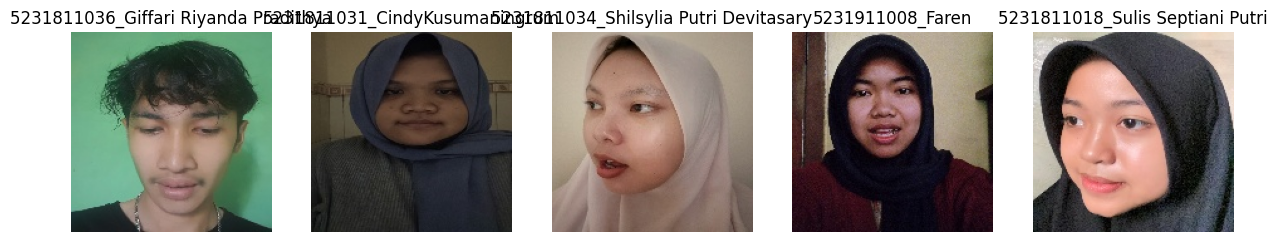

KESIMPULAN: Jika Anda melihat wajah di atas, berarti proses BERHASIL.


In [23]:
# CELL AUDIT: Pengecekan Visual Data
import matplotlib.pyplot as plt
import random

print(f"Status Data:")
print(f"1. Total Wajah Terkumpul: {len(X_faces)}")
print(f"2. Total Label: {len(y_labels)}")

if len(X_faces) > 0:
    print(f"3. Bentuk Data (Shape): {X_faces.shape}")
    # Harusnya (Jumlah_Wajah, 160, 160, 3)
    
    # Tampilkan 5 Sampel Acak
    plt.figure(figsize=(15, 5))
    indices = random.sample(range(len(X_faces)), min(5, len(X_faces)))
    
    for i, idx in enumerate(indices):
        plt.subplot(1, 5, i+1)
        plt.imshow(X_faces[idx]) # X_faces sudah RGB
        plt.title(y_labels[idx])
        plt.axis('off')
    
    plt.show()
    print("KESIMPULAN: Jika Anda melihat wajah di atas, berarti proses BERHASIL.")
else:
    print("\nKESIMPULAN: ❌ DATA KOSONG! Ada yang salah dengan Path atau Deteksi YOLO.")

In [10]:
# CELL 3: Generate Embedding & Train Classifier

if len(X_faces) == 0:
    print("Error: Tidak ada wajah yang terdeteksi. Cek path atau model YOLO Anda.")
else:
    print("1. Menggenerate Embeddings menggunakan FaceNet...")
    # FaceNet mengubah gambar (160x160) menjadi vektor 512-dimensi
    X_embeddings = embedder.embeddings(X_faces)

    print("2. Encoding Label...")
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y_labels)

    print("3. Melatih Model Klasifikasi (SVM)...")
    model_svm = SVC(kernel='linear', probability=True)
    model_svm.fit(X_embeddings, y_encoded)

    # Simpan model agar tidak perlu training ulang
    joblib.dump(model_svm, 'svm_face_model.pkl')
    joblib.dump(encoder, 'label_encoder.pkl')

    print("Pelatihan Selesai! Model SVM dan Encoder telah disimpan.")

1. Menggenerate Embeddings menggunakan FaceNet...
41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 383ms/step
2. Encoding Label...
3. Melatih Model Klasifikasi (SVM)...
Pelatihan Selesai! Model SVM dan Encoder telah disimpan.


In [18]:
# CELL 3.5: Evaluasi Model dengan Strategi Hybrid (YOLO + Haar Cascade)
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Load Model (Jaga-jaga jika restart kernel)
# Pastikan nama file sesuai dengan yang disimpan di Cell 3
if 'model_svm' not in locals():
    print("Memuat model dari file...")
    model_svm = joblib.load('svm_face_model.pkl') 
    encoder = joblib.load('label_encoder.pkl')

# Setup Backup Detector
haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

TEST_DIR = os.path.join(BASE_DIR, "Data test")
X_test_faces = []
y_test_labels = []

print("Memulai evaluasi data test (Menggunakan YOLO + Haar Backup)...")

files = os.listdir(TEST_DIR)
count_success = 0
count_fail = 0

for filename in files:
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        # 1. Parsing Label
        parts = filename.split('_')
        if len(parts) >= 2:
            true_label = f"{parts[0]}_{parts[1]}"
        else:
            continue

        img_path = os.path.join(TEST_DIR, filename)
        image = cv2.imread(img_path)
        if image is None: continue
        
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        face_img_found = None
        
        # === PLAN A: YOLO (Low Confidence) ===
        results = yolo_model(rgb_image, verbose=False, conf=0.25) # Conf diturunkan ke 0.25
        
        for result in results:
            boxes = result.boxes
            if len(boxes) > 0:
                x1, y1, x2, y2 = map(int, boxes[0].xyxy[0])
                face_img_found = image[y1:y2, x1:x2]
                break 

        # === PLAN B: HAAR CASCADE (Jika YOLO Gagal) ===
        if face_img_found is None or face_img_found.size == 0:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            faces_haar = haar_cascade.detectMultiScale(gray, 1.1, 4)
            if len(faces_haar) > 0:
                x, y, w, h = faces_haar[0]
                face_img_found = image[y:y+h, x:x+w]

        # === PROSES WAJAH ===
        if face_img_found is not None and face_img_found.size > 0:
            try:
                # Resize ke 160x160
                face_resized = cv2.resize(face_img_found, (160, 160))
                face_rgb = cv2.cvtColor(face_resized, cv2.COLOR_BGR2RGB) # Convert BGR to RGB
                
                X_test_faces.append(face_rgb)
                y_test_labels.append(true_label)
                count_success += 1
            except:
                count_fail += 1
        else:
            count_fail += 1
            # Opsional: Print file yang gagal total
            # print(f"Gagal deteksi: {filename}")

X_test_faces = np.array(X_test_faces)
y_test_labels = np.array(y_test_labels)

print(f"\nProses Selesai!")
print(f"Berhasil mendeteksi wajah: {count_success}")
print(f"Gagal mendeteksi wajah: {count_fail}")

if len(X_test_faces) > 0:
    # 2. Generate Embedding
    print("Menggenerate embeddings...")
    X_test_embeddings = embedder.embeddings(X_test_faces)

    # 3. Prediksi
    y_pred_indices = model_svm.predict(X_test_embeddings)
    y_pred_labels = encoder.inverse_transform(y_pred_indices)

    # 4. Report
    akurasi = accuracy_score(y_test_labels, y_pred_labels)
    print(f"\n=== HASIL AKHIR ===")
    print(f"Akurasi Total: {akurasi * 100:.2f}%")
    
    # Classification Report
    # Perhatikan kolom 'support', itu adalah jumlah foto yang berhasil terdeteksi per orang
    print("\nDetail per Mahasiswa:")
    print(classification_report(y_test_labels, y_pred_labels))
else:
    print("Tidak ada data test yang berhasil diolah.")

Memulai evaluasi data test (Menggunakan YOLO + Haar Backup)...

Proses Selesai!
Berhasil mendeteksi wajah: 864
Gagal mendeteksi wajah: 0
Menggenerate embeddings...
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 332ms/step

=== HASIL AKHIR ===
Akurasi Total: 95.72%

Detail per Mahasiswa:
                                          precision    recall  f1-score   support

                       5221911012_Debora       0.84      1.00      0.91        16
                       5221911025_Anggun       0.93      0.88      0.90        16
          5231811002_MichaelAndrewDeHaan       1.00      1.00      1.00        16
          5231811004_Hamdanu Fahmi Utomo       0.64      0.88      0.74        16
         5231811005_Akhmad Nabil Saputra       0.94      1.00      0.97        16
         5231811006_Daniel Granesa Kiara       0.84      1.00      0.91        16
         5231811007_Amalia Dwi Ramadhani       1.00      0.94      0.97        16
                       5231811008_Sophia       0.94      1.00      0.97 

In [21]:
# CELL 4: Real-time Face Recognition (DEBUG MODE)

# Load model (Pastikan sudah ada file .pkl nya)
if 'model_svm' not in locals():
    model_svm = joblib.load('svm_face_model.pkl')
    label_enc = joblib.load('label_encoder.pkl')

cap = cv2.VideoCapture(0) 

# --- SETTINGAN BARU ---
THRESHOLD = 0.5  # Kita turunkan dari 0.7 jadi 0.5 dulu
# ----------------------

print(f"Memulai kamera dengan Threshold: {THRESHOLD}")
print("Tekan 'q' untuk keluar.")

while True:
    ret, frame = cap.read()
    if not ret: break

    # Flip agar seperti cermin (opsional)
    frame = cv2.flip(frame, 1)
    
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # 1. Deteksi Wajah (Pakai YOLO conf rendah biar gampang dapat wajah)
    results = yolo_model(rgb_frame, verbose=False, conf=0.4)

    face_found = False
    
    for result in results:
        boxes = result.boxes
        for box in boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            
            # Cek class person
            if int(box.cls[0]) == 0:
                face_crop = rgb_frame[y1:y2, x1:x2]
                if face_crop.size == 0: continue

                try:
                    # 2. Preprocessing
                    face_resized = cv2.resize(face_crop, (160, 160))
                    face_sample = np.expand_dims(face_resized, axis=0)
                    
                    # 3. Embedding & Prediksi
                    embedding = embedder.embeddings(face_sample)
                    y_pred = model_svm.predict(embedding)
                    y_prob = model_svm.predict_proba(embedding)
                    
                    max_prob = np.max(y_prob)
                    name = label_enc.inverse_transform(y_pred)[0]

                    # --- LOGIKA TAMPILAN ---
                    # Kita tampilkan SIAPA tebakan model, meskipun probabilitas rendah
                    # Ini untuk ngecek apakah dia TEBAKANNYA BENAR tapi ragu, atau SALAH TEBAK.
                    
                    if max_prob < THRESHOLD:
                        # Tampilkan "Unknown" tapi beri info kecil tebakannya siapa
                        text_main = "Unknown"
                        text_sub = f"Mirip: {name} ({max_prob:.2f})"
                        color = (0, 0, 255) # Merah
                    else:
                        text_main = f"{name}"
                        text_sub = f"Prob: {max_prob:.2f}"
                        color = (0, 255, 0) # Hijau

                    # Gambar Kotak
                    cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
                    
                    # Tulis Nama Besar
                    cv2.putText(frame, text_main, (x1, y1 - 25), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
                    
                    # Tulis Info Probabilitas (Kecil)
                    cv2.putText(frame, text_sub, (x1, y1 - 5), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
                                
                except Exception as e:
                    print(e)

    cv2.imshow('Debug Face Recognition', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Memulai kamera dengan Threshold: 0.5
Tekan 'q' untuk keluar.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s